# Computing CIE Coordinates from Spectra
(short video demo [here](https://youtu.be/ZRFJSZF6mr0))

This notebook will demonstrate the use of the WPTherml package to compute the CIE coordinates from a 
spectrum.  The general idea is described concisely in [this page](http://www.brucelindbloom.com/index.html?Eqn_Spect_to_XYZ.html).  Given an emission spectrum $I_e(\lambda)$ the raw CIE coordinates ($X, Y,$ and $Z$) can be computed as 

\begin{align}
X = \int_{\lambda_1}^{\lambda_2}  I_e(\lambda) \bar{x}(\lambda) d\lambda \\
Y = \int_{\lambda_1}^{\lambda_2}  I_e(\lambda) \bar{y}(\lambda) d\lambda \\
Z = \int_{\lambda_1}^{\lambda_2} I_e(\lambda) \bar{z}(\lambda) d\lambda
\end{align}
where $\bar{x}(\lambda), \bar{y}(\lambda), \bar{z}(\lambda)$ are the CIE observer functions that encode the response of the color cones of the human eye.  We data from discrete samples of these observer functions
stored in [this file](https://github.com/FoleyLab/wptherml/blob/main/wptherml/data/cie_cmf.txt).  *Note: We need
to identify the source of this data!*

We are interested in noramalized CIE values, so we define a normalization constant from the raw CIE values,
$$ N = X + Y + Z, $$
and report normalized coordinates as follows:

\begin{align}
x = \frac{X}{N} \\
y = \frac{Y}{N} \\
z = \frac{Z}{N}.
\end{align}

With discretized samples of the emission spectra and the CIE observer functions, we can compute 
CIE coordinates through numerical integration, for example using the trapezoid rule.

WPTherml has a built-in method called `compute_cie(spectrum)` for performing the integrals shown above with the correct discretized
samples of CIE observer functions and the spectrum stored in an array called `spectrum`.  After 
reading in an emission spectrum of interest from a data file, we can deploy this `compute_cie()` method
to compute the CIE coordinates of this spectrum.

### Validating the CIE Coordinate Computation
The concept of a [Planckian Locus](https://en.wikipedia.org/wiki/Planckian_locus) is helpful for validating the `compute_cie()` method.  The Planckian Locus forms a path of colors (and corresponding CIE coordinates) that an ideal Blackbody emitter would have as a function of temperature.  There is also a simple approximation for the Planckian Locus as a function of temperature (see the cubic equation under the **Approximation** heading in the Wikipeadia Page linked above).  The following blocks of code will import the WPTherml package, create an instance of an incandescent emitter (in this case, a simple Tungsten slab), then compute the thermal emission spectrum of this slab, along with the thermal emission of an ideal blackbody, at a range of temperatures and compare the path of CIE $x$ and $y$ coordinates with those that lie along the Planckian locus.  The CIE coordinates of the Tungsten emitter should be close, though not necessarily on the Planckian locus, while the Blackbody values should exactly match (to within numerical roundoff error) the Planckian locus if our `compute_cie()` method is working properly.

 Your spectra have been computed! 😎 
 Your therml spectra have been computed! 🔥 


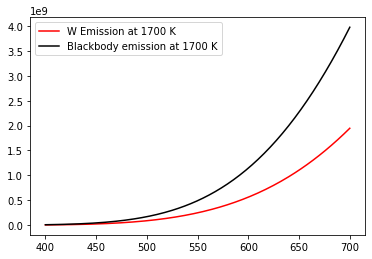

In [57]:
import wptherml
from matplotlib import pyplot as plt
import numpy as np

# create a tungsten incandescent object at 1700 K
tungsten_values = {
    "wavelength_list": [400e-9, 700e-9, 200],
    "Material_List": ["Air",  "W", "Air"],
    "Thickness_List": [0, 900e-9, 0],
    "temperature": 1700,
    "therml": True
}


sf = wptherml.SpectrumFactory()
w = sf.spectrum_factory('Tmm', tungsten_values)


plt.plot(w.wavelength_array * 1e9, w.thermal_emission_array, 'red', label="W Emission at 1700 K")
plt.plot(w.wavelength_array * 1e9, w.blackbody_spectrum, 'black', label="Blackbody emission at 1700 K")
plt.legend()
plt.show()

We can use the `compute_cie()` method to compute the CIE values of both the tungsten emitter
and the ideal blackbody emitter at 1700 K.  Because we have created this object with the name `w`, we
will utilize this method using the "dot notation" as follows:

`w.compute_cie(w.thermal_emission_array)`

`w.compute_cie(w.blackbody_spectrum)`

where the first call computes the CIE values of the actual thermal emission spectrum of tungsten at 1700 K, while
the second compute the CIE values of the ideal blackbody spectrum at 1700 K.  Both `thermal_emission_array` and 
`blackbody_spectrum` are attributes of the object named `w`, and `compute_cie` is a method of the object named `w`.  This is a concept in object oriented programming that is a little counterintuitive at first, but some good discription can be found [here](https://livebook.manning.com/concept/python/dot-notation).

Note that the `compute_cie()` method returns an array of CIE values (`[x, y, z]`), so the following
code block will store the CIE values of the ideal blackbody in an array called `bb_cie` and
the CIE values of tungsten in array called `w_cie`.

In [58]:
bb_cie = w.compute_cie(w.blackbody_spectrum)
w_cie = w.compute_cie(w.thermal_emission_array)

Let's print these arrays to see how similar/different they are from each other.  We expect they will
be similar, though not identical.  Remember incandescent bulbs use tungsten filaments, so we do expect
thermal emission to be similar to a blackbody source.

In [59]:
print(F'CIE Coordinates for W at 1700 K:                  {w_cie}')
print(F'CIE Coordinates for an ideal blackbody at 1700 K: {bb_cie}')

CIE Coordinates for W at 1700 K:                  [0.5567357482651879, 0.4062569179395491, 0.037007333795263025]
CIE Coordinates for an ideal blackbody at 1700 K: [0.5600855610920833, 0.40505713590886977, 0.03485730299904705]


Now we can compare the numerically computed values to the Planckian locus.  WPTherml has a built-in function
called `compute_planckian_locus()` that will compute the CIE coordinates on the Planckian locus utilizing the value of the temperature attribute of your class instance.  Again working with the class instance called `w`, we can use this function using the dot notation (`w.compute_planckian_locus()` and the relevant temperature value will be the temperature attribute of
the `w` class (`w.temperature` which we set to 1700 K in the first block).  
    


In [60]:
planck_cie = w.compute_planckian_locus()

In [61]:
print(F'CIE Coordinates for an ideal blackbody at 1700 K: {planck_cie}')

CIE Coordinates for an ideal blackbody at 1700 K: [0.5609411935680847, 0.4043036207558297, 0.0347551856760856]


We can visually inspect that all values from the Planckian locus are close to the values we computed
numerically from the Blackbody spectrum.  However, we can also have the computer make this check for us.  
There are a number of ways to do this, but one important method is to utilize an `assert` statement followed by a numerical comparison operation.  A powerful set of numerical comparison tools are provided by the numpy library,
with one example being `isclose(value1, value2, threshold)` for when you want to compare two scalar values and
see if they agree to within some numerical threshold, and another being `allclose(array1, array2, threshold)` for
when you want to see if the values of one array match the corresponding values of another array to within a numerical threshold.  This second is most appropriate here because we have two arrays of CIE values (one computed numerically, one computed from the Planckian locus), and we want to compare the values of these arrays.

In [62]:
assert np.allclose(planck_cie, bb_cie, 5e-3)

Finally, let's visualize the Planckian locus as obtained from the `compute_planckian_locus()` function (which should be basically exact) with the locus as obtained by calling `compute_cie(w.blackbody_spectrum)`
and `compute_cie(w.thermal_emission_array)`at a series of temperatures ranging from 1700 - 4000 K.  Hopefully the blackbody curve should be virtually indiscernible from the exact Planckian locus, and the W should look close but distinct.  These loci are typically plotted as a series of $x$ and $y$ values vs temperature, so that is what we will do.

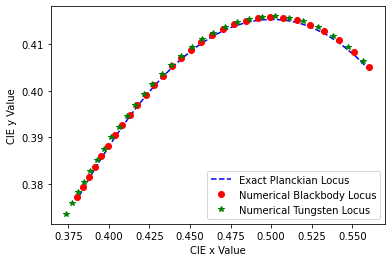

In [63]:
# Let's test our CIE calculator against the Planckian locus calculation
T_list = np.linspace(1700, 4000, 30)

# array to hold x-values of the Planckian locus, the blackbody, and the W emission for each temperature
planck_x = []
bb_x = []
w_x = []

# array to hold x-values of the Planckian locus, the blackbody, and the W emission for each temperature
planck_y = []
bb_y = []
w_y = []

for temp in T_list:
    # update the temperature attribute with the current value of temp
    w.temperature = temp
    
    # get Planckian locus at this temperature, store to planck_x and planck_y arrays 
    temp_cie = w.compute_planckian_locus()
    planck_x.append(temp_cie[0])
    planck_y.append(temp_cie[1])
    
    # numerically get blackbody locus at this temperature... need to update blackbody curve first
    w._compute_therml_spectrum(w.wavelength_array, w.emissivity_array)
    temp_cie = w.compute_cie(w.blackbody_spectrum)
    bb_x.append(temp_cie[0])
    bb_y.append(temp_cie[1])
    
    # get W emitter locus at this temperature, its thermal emission was updated when _compute_therml_spectrum
    # was called above
    temp_cie = w.compute_cie(w.thermal_emission_array)
    w_x.append(temp_cie[0])
    w_y.append(temp_cie[1])

    

plt.plot(planck_x, planck_y, 'b--', label='Exact Planckian Locus')
plt.plot(bb_x, bb_y, 'ro', label='Numerical Blackbody Locus')
plt.plot(w_x, w_y, 'g*', label='Numerical Tungsten Locus')
plt.xlabel("CIE x Value")
plt.ylabel("CIE y Value")
plt.legend()
plt.show()


# Items to-do:

1. Need to write a block that parses spectra files that Abhishek provides and stores these results to a wavelength array and an emission spectrum array.  
- These data are in a folder called `Meth_and_Butoxy_TTz` and have file extensions `.txt`.  I think we can use the glob library for this!

2. Make sure spectral data from Abhishek's file and the CIE observer functions are on the same wavelength grid... think about ways to do this that are elegant / robust
- The data are on a wavelength grid from 400-790 nm.  We can fit a spline to this data using scipy's interpolation capabilities e.g. 
`emission_spline = InterpolatedUnivariateSpline(wavelength_data, emission_data, k=1)`


3. Feed his spectra to compute_cie(spectra) and store values to return to him

### Bonus to-do:

1. Can we write a function that takes a few parameters (e.g. peak wavelengths, spectral widths, and peak intensities) for several dyes and approximates the total emission as a sum of gaussians and computes the CIE value from that approximation?

In [86]:
import os
from scipy import interpolate
import glob

In [88]:
file_location = os.path.join('Meth_and_Butoxy_TTz','*.txt')
filenames = glob.glob(file_location)
print(filenames)

['Meth_and_Butoxy_TTz/4.2.txt', 'Meth_and_Butoxy_TTz/6.1.txt', 'Meth_and_Butoxy_TTz/4.3.txt', 'Meth_and_Butoxy_TTz/4.1.txt', 'Meth_and_Butoxy_TTz/6.3.txt', 'Meth_and_Butoxy_TTz/6.2.txt', 'Meth_and_Butoxy_TTz/2.2.txt', 'Meth_and_Butoxy_TTz/2.3.txt', 'Meth_and_Butoxy_TTz/2.1.txt', 'Meth_and_Butoxy_TTz/7.3.txt', 'Meth_and_Butoxy_TTz/5.1.txt', 'Meth_and_Butoxy_TTz/7.2.txt', 'Meth_and_Butoxy_TTz/5.2.txt', 'Meth_and_Butoxy_TTz/5.3.txt', 'Meth_and_Butoxy_TTz/7.1.txt', 'Meth_and_Butoxy_TTz/3.1.txt', 'Meth_and_Butoxy_TTz/1.3.txt', 'Meth_and_Butoxy_TTz/1.2.txt', 'Meth_and_Butoxy_TTz/3.2.txt', 'Meth_and_Butoxy_TTz/1.1.txt', 'Meth_and_Butoxy_TTz/3.3.txt', 'Meth_and_Butoxy_TTz/11.3.txt', 'Meth_and_Butoxy_TTz/11.2.txt', 'Meth_and_Butoxy_TTz/11.1.txt', 'Meth_and_Butoxy_TTz/9.3.txt', 'Meth_and_Butoxy_TTz/9.2.txt', 'Meth_and_Butoxy_TTz/9.1.txt', 'Meth_and_Butoxy_TTz/10.1.txt', 'Meth_and_Butoxy_TTz/10.3.txt', 'Meth_and_Butoxy_TTz/10.2.txt', 'Meth_and_Butoxy_TTz/8.1.txt', 'Meth_and_Butoxy_TTz/8.3.txt', '

In [89]:
for file in filenames:
    data = np.loadtxt(file)
    emission_spline = interpolate.interp1d(data[:,0], data[:,1])
    emission_prediction = emission_spline(w.wavelength_array * 1e9)   
    cie = w.compute_cie(emission_prediction)
    print(F"cie for file {file} is {cie}")
# data[:,0] -> wavelengths in nm
# data[:,1] -> emission intensity
#print(data)

cie for file Meth_and_Butoxy_TTz/4.2.txt is [0.2376624562792153, 0.26428103133240893, 0.4980565123883757]
cie for file Meth_and_Butoxy_TTz/6.1.txt is [0.1843644027307847, 0.18990891565547152, 0.6257266816137438]
cie for file Meth_and_Butoxy_TTz/4.3.txt is [0.21462838170558254, 0.24162551834020488, 0.5437460999542126]
cie for file Meth_and_Butoxy_TTz/4.1.txt is [0.21965342704682286, 0.23303945573895693, 0.5473071172142202]
cie for file Meth_and_Butoxy_TTz/6.3.txt is [0.1832648942595531, 0.1896346940991123, 0.6271004116413347]
cie for file Meth_and_Butoxy_TTz/6.2.txt is [0.18391588030623102, 0.19053152986459568, 0.6255525898291733]
cie for file Meth_and_Butoxy_TTz/2.2.txt is [0.37289520272863225, 0.42387606094673796, 0.20322873632462984]
cie for file Meth_and_Butoxy_TTz/2.3.txt is [0.3708359654800134, 0.42738276672322967, 0.2017812677967569]
cie for file Meth_and_Butoxy_TTz/2.1.txt is [0.36845249732223373, 0.42620482507908974, 0.2053426775986765]
cie for file Meth_and_Butoxy_TTz/7.3.txt 

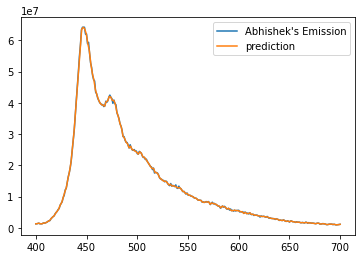

In [83]:
plt.plot(data[:,0], data[:,1], label="Abhishek's Emission")
plt.plot(w.wavelength_array * 1e9, emission_prediction, label="prediction")
plt.legend()
plt.show()

In [84]:
abhishek_cie_51 = w.compute_cie(emission_prediction)

In [85]:
print(abhishek_cie_51)

[0.190305991044037, 0.1966850220478991, 0.6130089869080639]
